In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
msft = yf.Ticker("msft")
data = msft.history(period="max")
plt.style.use('seaborn')

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_13152\12997108.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [3]:
close_prices = data["Close"]
values = close_prices.values
training_data_len = math.ceil(len(values) * 0.7)

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(values.reshape(-1, 1))
train_data = scaled_data[0:training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [5]:
test_data = scaled_data[training_data_len-60:,:]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [6]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
6479/6479 [==============================] - 323s 49ms/step - loss: 1.9601e-05
Epoch 2/3
6479/6479 [==============================] - 321s 50ms/step - loss: 6.2424e-06
Epoch 3/3
6479/6479 [==============================] - 317s 49ms/step - loss: 5.2323e-06


In [8]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)

88/88 [==============================] - 7s 53ms/step


C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_13152\2850150816.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


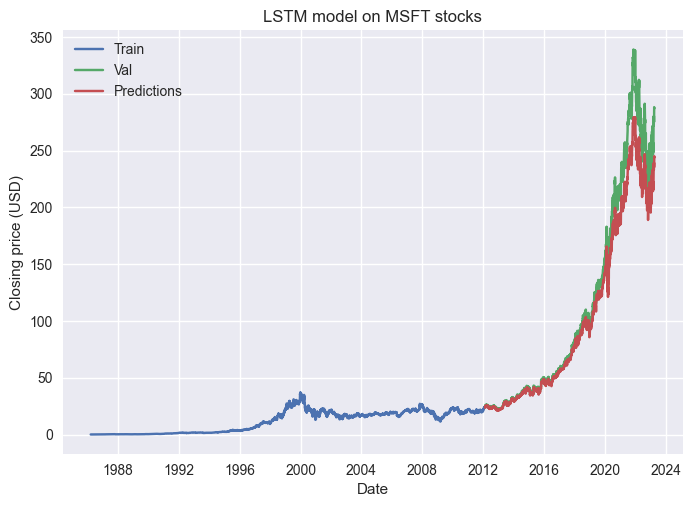

In [9]:
data = data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
# validation = validation[-50:]
plt.title('LSTM model on MSFT stocks')
plt.xlabel('Date')
plt.ylabel('Closing price (USD)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'])
plt.show()

In [10]:
from sklearn.metrics import r2_score

In [11]:
print(f"r2_score: {r2_score(validation['Close'], validation['Predictions'])}")
print(f"RMSE: {rmse}")

r2_score: 0.9574179864859392
RMSE: 11.443950907661607


In [12]:
import numpy as np

validation['Change'] = np.nan
validation['Pred Change'] = np.nan
validation['Change'][0] = 0
validation['Pred Change'][0] = 0

for i in range(len(validation) - 1):
    j = i + 1
    if validation['Close'][i] < validation['Close'][j]:
        validation['Change'][j] = 1
    else:
        validation['Change'][j] = 0

for i in range(len(validation) - 1):
    j = i + 1
    if validation['Predictions'][i] < validation['Predictions'][j]:
        validation['Pred Change'][j] = 1
    else:
        validation['Pred Change'][j] = 0

C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_13152\2128503046.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Change'] = np.nan
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_13152\2128503046.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Pred Change'] = np.nan
C:\Users\Kacper.pucylo\AppData\Local\Temp\ipykernel_13152\2128503046.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

<AxesSubplot: >

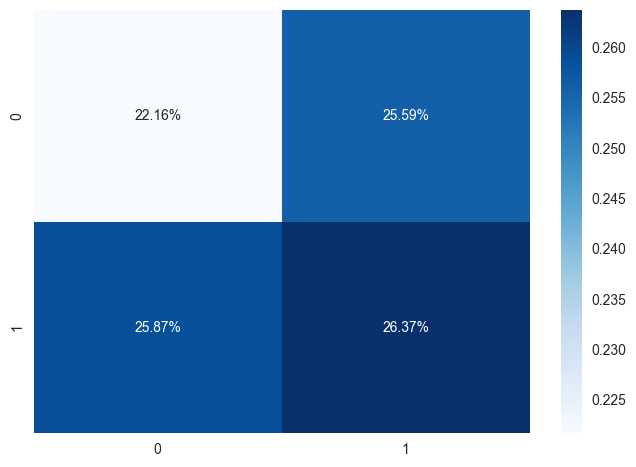

In [14]:
cf_matrix = confusion_matrix(validation['Change'], validation['Pred Change'])

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [15]:
validation.head()

,Close,Predictions,Change,Pred Change
Date,,,,
2012-02-15 00:00:00-05:00,24.194941,23.700485,0.0,0.0
2012-02-16 00:00:00-05:00,25.193336,23.566212,1.0,0.0
2012-02-17 00:00:00-05:00,25.161133,24.531382,0.0,1.0
2012-02-21 00:00:00-05:00,25.314117,24.425148,1.0,0.0
2012-02-22 00:00:00-05:00,25.177240,24.613968,0.0,1.0
